In [87]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

Non-parametric methods use a generic learning function of the form

$$
f_\mathcal{G}(\mathbf{x}|\mathbf{c}) = \sum_{i=1}^{n}c_iG(\mathbf{x}-\mathbf{x_i}) = \sum_{i=1}^{n}c_i\gamma_i(x)
$$

Where G is a symmetric kernel function which is used to generate a generic basis function $\gamma_i$ for every data point $\mathbf{x_i}$. Unlike a polynomial basis, these kernels are localized, e.g., A Gaussian kernel $G(\mathbf(x)) = exp(||\mathbf{x}||^2/\sigma)$, limiting the influence of each basis function to a subregion of the input space. This enables the non-parametric model to accurately fit the training data from a wide variety of systems. However, non-parametric models have up to n degrees of freedom which makes them very prone to over-fitting.

In [88]:
def gaussian_kernel(x, xi, sigma=1):
    """
    The gaussian kernel G(x-xi) = (1/(sqrt(2pi)*sigma))*e^(-0.5||x||^2)
    """
    x = np.atleast_2d(x)
    xi = np.atleast_2d(xi)
    sq_norm = -0.5 * spatial.distance.cdist(x, xi, 'sqeuclidean')
    return np.exp(sq_norm/sigma**2)

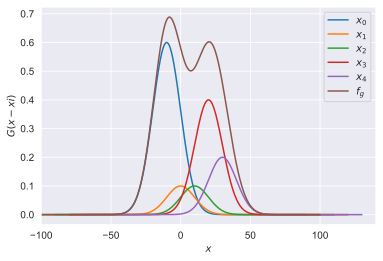

In [89]:
fig, ax = plt.subplots()
sigma=10
xc = [-10, 0, 10, 20, 30]
ci = [0.6, 0.1, 0.1, 0.4, 0.2]
x_pred = np.linspace(-100, 100, 1000).reshape(-1, 1)
f_g = []
for i, (x_i, c_i) in enumerate(zip(xc, ci)):
    x = np.linspace(x_i-10*sigma, x_i+10*sigma, 1000).reshape(-1, 1)
    g_x = c_i*gaussian_kernel(x, x_i, sigma=sigma)
    f_g += [c_i * gaussian_kernel(x_pred, x_i, sigma=sigma)]
    ax.plot(x, g_x, label=f'$x_{i}$')
f_g = np.sum(f_g, axis=0)
ax.plot(x_pred, f_g, label=r'$f_g$')
ax.set_xlim((-100, 140))
ax.set_xlabel(f'$x$')
ax.set_ylabel(f'$G(x-xi)$')
ax.legend()

Regularization (also known as ridge regression) reduces over-fitting by introducing a 'statistical-insight' to the GLM, namely: smooth predicitons tend to generalie better to unseen data. To regularize a GLM, the parameters are optimized by minimizing a regularized error metric:

$$
J(\mathbf{w}) = (\mathbf{y}-\mathbf{Xw})^T(\mathbf{y}-\mathbf{Xw})+\lambda||\mathbf{w}||^2
$$

The optimal solution is given by

$$
\mathbf{w} = (\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I}_D)^{-1}\mathbf{X}^T\mathbf{y}
$$

The equation is not yet in the form of inner products. However, using the matrix inversion lemma we rewrite the ridge estimate as follows

$$
\mathbf{w} = \mathbf{X}^T(\mathbf{X}\mathbf{X}^T+\lambda\mathbf{I}_N)^{-1}\mathbf{y}
$$

We can partially kernelize this, by replacing $\mathbf{XX}^T$ with the Gram matrix $\mathbf{K}$. But what about the leading $\mathbf{X}^T$ term?
Let us definte the following <b>duel variables</b>:

$$
\mathbf{\alpha} = (\mathbf{K}+\lambda\mathbf{I}_N)^{-1}\mathbf{y}
$$

Then we can rewrite the <b>primal variables</b> as follows

$$
\mathbf{w} = \mathbf{X}^T\mathbf{\alpha} = \sum_{i=1}^N\alpha_ix_i
$$

This tells us that the solution vector is just a linear sum of the N training vectors. When we plub this in at test time to compute the predictive mean, we get

$$
\hat{f}(\mathbf{x})=\mathbf{w}^T\mathbf{x}=\sum_{i=1}^{N}\alpha_i\mathcal{k}(\mathbf{x}, \mathbf{x}_i) = \mathbf{\alpha K}
$$

In [90]:
beta = 3
omega = 8*np.pi
alpha = 1
phi = 0.15*np.pi

def f(t):
    return alpha*np.tanh(beta*t)*np.sin(omega*t + phi)

var = np.var(f(np.linspace(0, 1, 1000)))

def noisy_f(x, percent=0.1):
    f_x = f(x)
    v = (percent**2*var)
    np.random.seed(4)
    return f(x)+np.random.normal(0, scale=v, size=x.shape)

In [101]:
y_test.shape

(1000,)

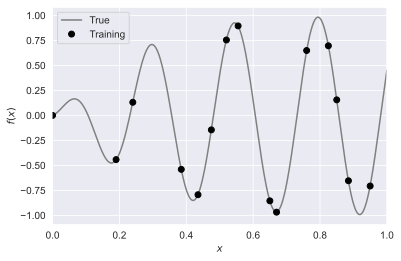

In [100]:
np.random.seed(5)
N = 15
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_test = f(X_test)[:, 0]
X_train = np.array([0, 0.19, 0.24, 0.385, 0.435, 0.475, 0.52, 0.555, 0.65, 0.67, 0.76, 0.825, 0.85, 0.885, 0.95])#np.random.uniform(0, 1, N).reshape(-1, 1)#np.linspace(0, np.pi, 10, 'o').reshape(-1, 1)
X_train = np.atleast_2d(X_train).T
y_train = noisy_f(X_train)[:, 0]

fig, ax = plt.subplots()
ax.plot(X_test, y_test, c='grey', linestyle='-', label="True")
ax.plot(X_train, y_train, 'ko', label='Training', zorder=3)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim(0, 1)
ax.legend()

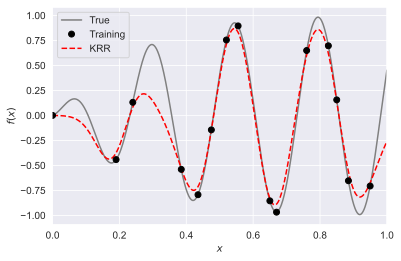

In [98]:
sigma = 0.05  # Length scale
_lambda = 0.1 # Regularization strength
K_test = gaussian_kernel(X_train, X_train, sigma=sigma)
K_test += _lambda * np.identity(X_train.shape[0])
duel_variables = np.linalg.solve(K_test, y_train)
K_pred = gaussian_kernel(X_test, X_train, sigma)
y_pred = np.dot(K_pred, duel_variables)

fig, ax = plt.subplots()
ax.plot(X_test, y_test, c='grey', linestyle='-', label="True")
ax.plot(X_train, y_train, 'ko', label='Training', zorder=3)
ax.plot(X_test, y_pred, 'r--', label='KRR', zorder=2)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim(0, 1)
ax.legend()

(-1.5, 1.5)

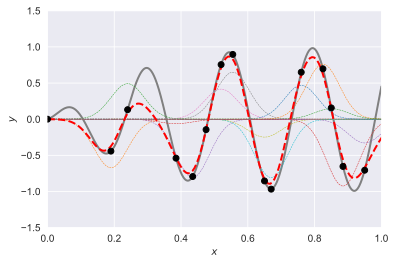

In [99]:
fig, ax = plt.subplots()
f_g = []
ax.plot(X_test, y_test, c='grey', linestyle='-', linewidth=2, label="True")
ax.plot(X_train, y_train, 'ko', label='Training', zorder=3)
for i, (x_i, c_i) in enumerate(zip(X_train.ravel(), duel_variables.ravel())):
    x = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
    g_x = c_i*gaussian_kernel(x, x_i, sigma=sigma)
    f_g += [g_x]
    ax.plot(x, g_x, linestyle='--', linewidth=.5, label=f'$x_{{{i}}}$')
ax.plot(x, np.sum(f_g, axis=0), 'r--', linewidth=2, label=r'KRR')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(0, 1)
ax.set_ylim(-1.5, 1.5)
#ax.legend(loc=1)